In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
import tensorflow.keras.optimizers as optimizers
import os, glob, math
from PIL import Image
import matplotlib.pyplot as plt

# 0. Data Analysis
We first need to check whether the data are consistent, in terms of image dimension.

In [3]:
train_width, train_height = [], []
train_channel = set()
test_width, test_height = [], []
test_channel = set()

In [4]:
for animal in ['dogs', 'cats']:
    animaux = animal[:-1]
    for fname in glob.glob(os.path.join('data', 'train', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
    for fname in glob.glob(os.path.join('data', 'validation', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        test_width.append(w)
        test_height.append(h)
        test_channel.add(im.getbands())

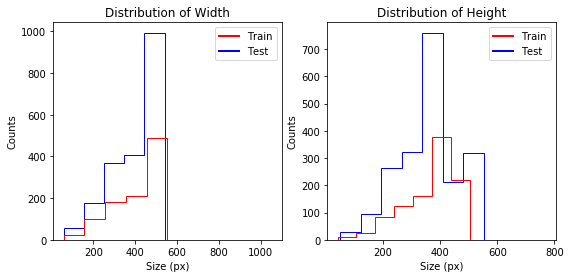

In [5]:
fig = plt.figure(figsize=(9, 4))
from matplotlib.lines import Line2D
custom_lines = [Line2D([1], [1], color='red', lw=2),
                Line2D([1], [1], color='blue', lw=2)]
plt.subplot(1, 2, 1)
plt.title('Distribution of Width')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_width, label='trainWidth', color='blue', histtype='step')
plt.hist(test_width, label='testWidth', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.subplot(1, 2, 2)
plt.title('Distribution of Height')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_height, label='trainHeight', color='blue', histtype='step')
plt.hist(test_height, label='testHeight', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.show()

In [6]:
df_dist = pd.DataFrame(index=['MedianWidth', 'MedianHeight'])
from fractions import Fraction
df_dist['Train'] = pd.Series({'MedianWidth': np.median(train_width),
                              'MedianHeight': np.median(train_height)})
df_dist['Test'] = pd.Series({'MedianWidth': np.median(test_width),
                              'MedianHeight': np.median(test_height)})
df_dist['Average'] = df_dist.mean(axis=1)
df_dist = df_dist.astype(int)
display (df_dist)

,Train,Test,Average
MedianWidth,442,448,445
MedianHeight,374,374,374


In [7]:
train_channel, test_channel

({('R', 'G', 'B')}, {('R', 'G', 'B')})

# 1. Model Initialisation & Training
We know that the colour channels are concordant between the datasets, i.e. RGB, so we can hardcode it appropriately during data loading. Also, due to the distribution of the dataset dimensions, let's take and rescale to the average of the median values.

In [8]:
BATCH_SIZE = 32
epochs = 5
AVG_MED_WIDTH = 200#int(df_dist.loc['MedianWidth', 'Average']/2)
AVG_MED_HEIGHT = 200#int(df_dist.loc['MedianHeight', 'Average']/2)
print (f'AVG MED WIDTH {AVG_MED_WIDTH}')
print (f'AVG MED HEIGHT {AVG_MED_HEIGHT}')

AVG MED WIDTH 200
AVG MED HEIGHT 200


In [9]:
print ("Getting Training Data")
train_data = ImageDataGenerator(
                rescale=1./255, 
#                 rotation_range=15,
                width_shift_range=0.1, 
                height_shift_range=0.1, 
                horizontal_flip=True,
                vertical_flip=True,
                validation_split=0.1
                )

print ("Subsampling Validation Set")
validation_data = train_data.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'train'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='validation')

print ("Subsampling Training Set")
train_data = train_data.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'train'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='training')

print ("Test Data")
test_data = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'validation'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'])

Getting Training Data
Subsampling Validation Set
Found 200 images belonging to 2 classes.
Subsampling Training Set
Found 1800 images belonging to 2 classes.
Test Data
Found 1000 images belonging to 2 classes.


In [10]:
sample_train, label = next(train_data)
num_train_data = train_data.n
num_val_data = validation_data.n
num_test_data = test_data.n

In [11]:
labelName = {0.:'cats', 1.:'dogs'}

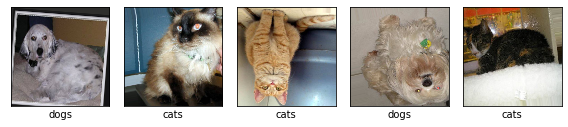

In [12]:
def plotImages(images_arr, label_arr):
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        ax.imshow(img)
        ax.set_xlabel(labelName[dataLabel])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

plotImages(sample_train[:5], label[:5])

In [13]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform',
                           input_shape=(AVG_MED_WIDTH, AVG_MED_HEIGHT, 3)),
    MaxPooling2D(2, strides=1),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(2, strides=1),    
#     Dropout(0.2),    
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(2, strides=1),
    Dropout(0.4),    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(256),
    Dense(1, activation='sigmoid')
    ])
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 199, 199, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 198, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 198, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 2509056)           0

In [14]:
def plotHistory(history):
    fig = plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.title('Training Scores')
    plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
    plt.plot(history.history['Precision'], color='red', label='Precision')
    plt.plot(history.history['Recall'], color='green', label='Recall')
    plt.plot(history.history['AUC'], color='magenta', label='AUC')
    plt.plot(history.history['val_accuracy'], '--', color='blue', label='valAccuracy')
    plt.plot(history.history['val_Precision'], '--', color='red', label='valPrecision')
    plt.plot(history.history['val_Recall'], '--', color='green', label='valRecall')
    plt.plot(history.history['val_AUC'], '--', color='magenta', label='valAUC')
    plt.xticks(range(0, epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title('Loss')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.xticks(range(epochs+1))
    plt.plot(history.history['loss'], color='black', label='Loss')
    plt.show()
    


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 57 steps, validate for 7 steps
Epoch 1/5
57/57 [==============================] - 202s 4s/step - loss: 103.7548 - accuracy: 0.4939 - AUC: 0.4976 - Precision: 0.4899 - Recall: 0.2978 - val_loss: 0.6941 - val_accuracy: 0.5000 - val_AUC: 0.5456 - val_Precision: 0.5000 - val_Recall: 1.0000
Epoch 2/5
57/57 [==============================] - 189s 3s/step - loss: 0.6972 - accuracy: 0.5000 - AUC: 0.4994 - Precision: 0.5000 - Recall: 0.4133 - val_loss: 0.6971 - val_accuracy: 0.5000 - val_AUC: 0.5407 - val_Precision: 0.5000 - val_Recall: 1.0000
Epoch 3/5
57/57 [==============================] - 190s 3s/step - loss: 0.6959 - accuracy: 0.5061 - AUC: 0.5000 - Precision: 0.5037 - Recall: 0.8267 - val_loss: 0.6965 - val_accuracy: 0.5000 - val_AUC: 0.5050 - val_Precision: 0.5000 - val_Recall: 1.0000
Epoch 4/5
57/57 [==============================] - 190s 3s/step - loss: 0.6949 - accuracy: 0.4806 - AUC: 0.4790 - Precision: 0.4816 - Recall: 0.5

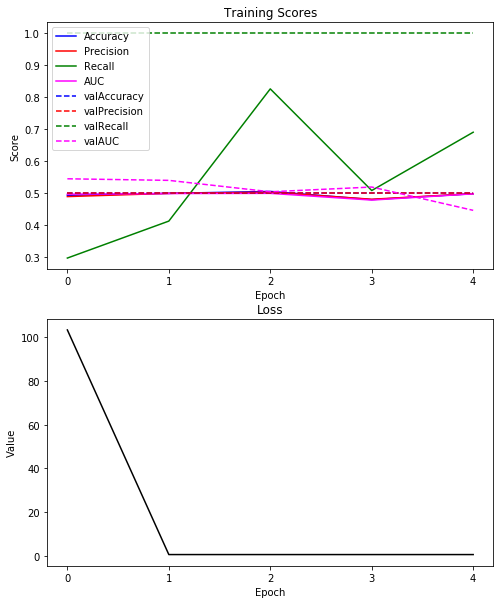

In [16]:
plotHistory((model.fit(train_data, 
                    steps_per_epoch=math.ceil(num_train_data/BATCH_SIZE), 
                    epochs=epochs,
                    validation_data=validation_data
                    )))